## Python examples in Sambridge et al. (2022): Ricker wavelets

This Jupyter notebook contains python code to illustrate calculations made in 

Sambridge, Jackson & Valentine (2022), [Geophysical Inversion and Optimal Transport](https://doi.org/10.1093/gji/ggac151), *Geophysical Journal International*.

This notebook demonstrates calculations involving Double Ricker wavelets in Figures 3 & 8.

### Import libraries

In [1]:
# read standard libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.optimize import minimize

from libs import ricker_util as ru # Import interface to OT calculation library as well as utility routines

-------

### Optimal Transport libraries

This notebook makes use of the following python scripts:

`ricker_util.py` contains various utility plot routines used in this notebook, but also acts as an interface to two independent libraries: 

- `OTlib.py` containing the author's Optimal Transport calculation library for 1D and 2D densities fields together with derivatives.

- `FingerprintLib.py` containing routines required to calculate nearest distance fields and 2D densities for time series together with their derivatives of density field with respect to time series amplitude.


-------

## Iterative fitting of Ricker wavelets by minimizing Wasserstein distance

Here we set up an otimization problem fitting double Ricker wavelets using the Wasserstein misfit between their 2D fingerprints.

Parameters for optimization are 
- timeshift between wavelets, 
- amplitude scale factor, and 
- spread parameter of Ricker wavelet.

The target 'observed' Ricker wavelet has added uncorrelated (white) or correlated and noise addition. 

Wasserstein distances are calculated with the marginal algorithms for 2D PDFs.

This notebook performs 3D parameter inversion using a gradient algorithm and plots results W_p or L_2 norm convergence.

---

### Define Observed wavelet


Makes use of the routine `ricker` which is defined with a reference frequency of 25Hz corresponding to a single ricker wavelet of 0.128 s. Here we use a double ricker wavelet over the interval `(trange[0],trange[1])`. For (-2,2) this corresponds to a single ricker time window length of 2s and hence a frequency of `mtrue[2] = 1.0` corresponds to 15.625 Hz reference signal, or reference period 0.064 s.

Hence a noise correlation length of 0.03s corresponds to 47% of the reference period.

Noise amplitude of 0.08 corresponds to 4.84 % of the maximum observed waveform height.

### Ricker wavelets as a function of three parameters

In Sambridge et al. (2022) we set up an otimization problem fitting double Ricker wavelets using the Wasserstein misfit between their 2D fingerprints.

Parameters for optimization are: 
- timeshift between wavelets, 
- amplitude scale factor, and 
- spread parameter of Ricker wavelet.

These constitute the three parameters upon which our double Ricker wavelet depends. In Sambridge et al. (2022) we set up an optimisation problem to solve for these parameters.

The target 'observed' Ricker wavelet has added correlated, and the predicted wavelet no noise. This forms a simple three parameter optimisation problem.

In [2]:
trange = [-2.,2.] # range of observed double Ricker wavelet
mtrue = np.array([0.,1.6,1.]) # define true model parameters, toffset, amplitude, f-factor
mstart = np.array([5.0,0.8, 0.8]) # starting guess (ref)
mstart = np.array([5.0,0.5, 0.5]) # starting guess (low amp)
mstart = np.array([5.0,3.0, 0.5]) # starting guess (high amp)
tpred,wpred = ru.rickerwavelet(mstart[0],mstart[1],mstart[2],trange=trange) # set up test waveform
tobs,wobs = ru.rickerwavelet(mtrue[0],mtrue[1],mtrue[2],sigma_amp=0.08,sigma_cor=0.03,trange=trange,seed=61254557) # create observed noisy waveform
#tobs,wobs = rickerwavelet(mtrue[0],mtrue[1],mtrue[2],sigma_amp=0.00,sigma_cor=0.03,trange=trange,seed=61254557) # create observed noiseless waveform


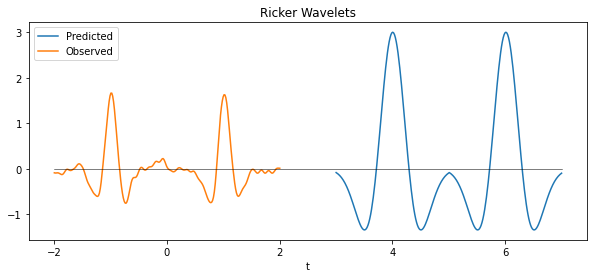

In [3]:
ru.plotrickers(tpred,wpred,tobs,wobs)

#### Setup for OT 

In [4]:
# choose parameters
nugrid,ntgrid=40,512 # default discretization of fingerprint window
lambdav = 0.03       # scale parameter for PDF of fingerprint
alpha = 0.5          # mixing parameter for time and amplitude wasserstein misfits
transform = False    # use arctan amplitude transform
theta = 45.0         # angle in degrees for distance metric weighting between time and amplitude to calculate distance field

#### Setup Time-Amplitude window 

Calculate time amplitude window, and plot the waveform neareest distance functions.

In [5]:
# set up Fingerprint windows
if(transform): # if we are using time-amplitude transform adjust amplitude ranges to data
    grid = (trange[0], trange[1], -0.8, 1.5, 2*nugrid,ntgrid) # set up time-amplitude window about data (high amp start) with arctan transform
else:
    grid = (trange[0], trange[1], -1.00, 2.0, 2*nugrid,ntgrid) # set up fixed time-amplitude window about data (low amp start)
    grid = (trange[0], trange[1], -2.00, 3.5, 2*nugrid,ntgrid) # set up fixed time-amplitude window about data (high amp start)
    
# build observed and initial predicted waveform object
wfobs, wfobs_target = ru.BuildOTobjfromWaveform(tobs,wobs,grid,lambdav=lambdav,transform=transform,theta=theta) # build data object
wfpred, wfpred_source = ru.BuildOTobjfromWaveform(tpred,wpred,grid,lambdav=lambdav,transform=transform,theta=theta) # build data object

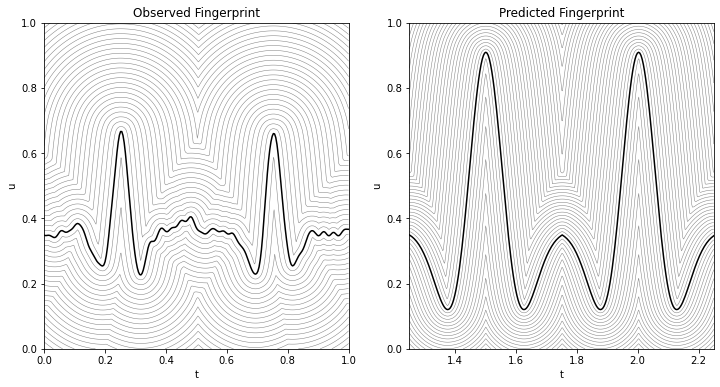

In [6]:
#plot finger prints
ru.fp.plot_2LS(wfobs,wfpred,'Observed Fingerprint','Predicted Fingerprint','black','grey',filename='Figures/Ricker_fingerprints.pdf',fxsize=12,fysize=6) 


This is the fingerprint in the actual model space window. here the reference plot om the right has higher amplitude than the noisy waveform on the left.

#### Plot Marginals

Calculate and plot initial predicted and observed marginals.

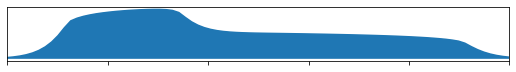

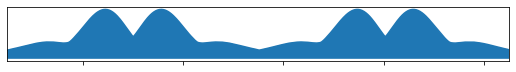

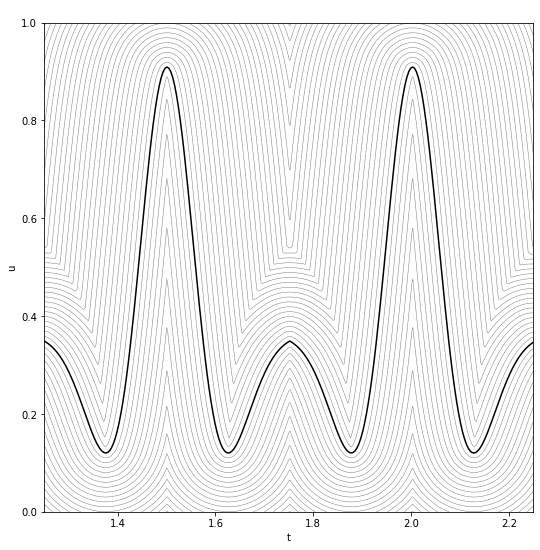

In [7]:
ru.plotMarginals(wfpred,wfpred_source,tag='_pred')

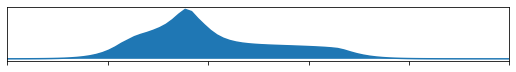

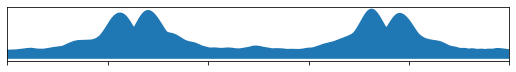

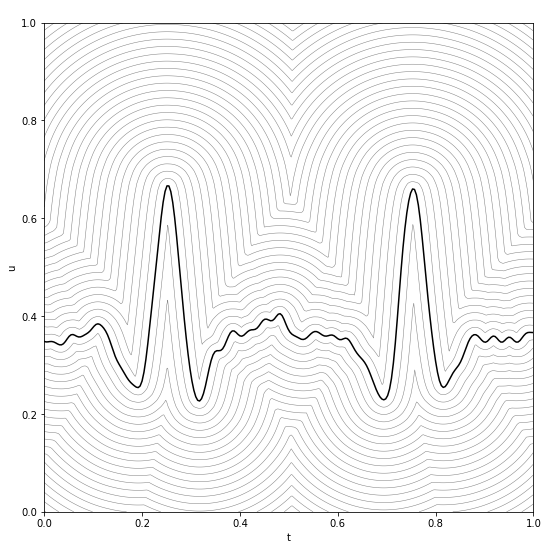

In [8]:
ru.plotMarginals(wfobs, wfobs_target,tag='_obs')

This is how the components of Figure 3 of Sambridge et al. (2022), are calculated. 

#### Wasserstein misfits between time and amplitude marginals

A demonstration of calling the Wasserstein distances between time and amplitude marginals.

In [9]:
w1 = ru.CalcWasserWaveform(wfpred_source,wfobs_target,wfpred,distfunc='W1',returnmarg=True)
w2 = ru.CalcWasserWaveform(wfpred_source,wfobs_target,wfpred,distfunc='W2',returnmarg=True)
print(' W1 Wasserstein misfits between initial waveforms (time,amplitude) marginals :',w1) 
print(' W2 Wasserstein misfits between initial waveforms (time,amplitude) marginals :',w2) 
w1 = ru.CalcWasserWaveform(wfpred_source,wfobs_target,wfpred,distfunc='W1')
w2 = ru.CalcWasserWaveform(wfpred_source,wfobs_target,wfpred,distfunc='W2')
print(' Average W1 Wasserstein misfits between initial waveforms:',w1) 
print(' Average W2 Wasserstein misfits between initial waveforms:',w2) 

 W1 Wasserstein misfits between initial waveforms (time,amplitude) marginals : [[1.252826770035104, 0.10250639416295368]]
 W2 Wasserstein misfits between initial waveforms (time,amplitude) marginals : [[1.5697188486885025, 0.014380736561780717]]
 Average W1 Wasserstein misfits between initial waveforms: 0.6776665820990287
 Average W2 Wasserstein misfits between initial waveforms: 0.7920497926251416


### Perform optimization of Wasserstein distance for Ricker model parameters

Set up data object for minimization routine. `mtrue=(0. , 1.6, 1.)`. 

Here we perform minimization of the Wasserstein distance to find the model parameters that best fit the noisy double ricker waveform.

In [10]:
data = [wfobs_target,'W2',trange,grid,lambdav,transform,alpha,theta] # data list for use with scipy minimize (see ru.optfunc for specs)

In [11]:
# Initialize optimization
from libs import ricker_util_opt
ricker_util_opt.init()
ricker_util_opt.Wits = [mstart.tolist()] # initialize list of iterative models found during optimization
tpred,wpred = ru.rickerwavelet(mstart[0],mstart[1],mstart[2],trange=trange) # set up test waveform

Use scipy minimize to iteratively reduce Wasserstein distance as a function of model parameters.

In [12]:
opt1 = minimize(ru.optfunc, mstart, data, jac=True, tol=1E-8,method='L-BFGS-B',
                options={'disp': True,'maxiter': 500},callback=ru.recordresult)
print(opt1)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.92050D-01    |proj g|=  3.13207D-01


 This problem is unconstrained.


[4.00054836 2.97158386 0.51699831]

At iterate    1    f=  5.09865D-01    |proj g|=  2.50750D-01
[-0.02066424  2.71442389  0.73629797]

At iterate    2    f=  4.02058D-03    |proj g|=  6.92089D-03
[-0.01237765  2.1592865   0.86762362]

At iterate    3    f=  1.01578D-03    |proj g|=  3.47382D-03
[-0.01215407  1.58903513  0.88294323]

At iterate    4    f=  5.58037D-05    |proj g|=  1.29736D-04
[-0.01077599  1.60958872  0.88277108]

At iterate    5    f=  5.35508D-05    |proj g|=  3.12592D-05
[-0.01076     1.61643637  0.88438188]

At iterate    6    f=  5.35022D-05    |proj g|=  1.54955D-05
[-0.01076279  1.61287723  0.88762668]
At iterate    7    f=  5.34492D-05    |proj g|=  1.38669D-05

[-0.01074882  1.61243919  0.89365292]

At iterate    8    f=  5.33971D-05    |proj g|=  4.54537D-05
[-0.0107655   1.61623423  0.89893679]

At iterate    9    f=  5.33347D-05    |proj g|=  5.57454D-06
[-0.01079018  1.61869592  0.90585804]

At iterate   10    f=  5.33209D-05    |proj g|=  7.67329D-07
[-0

In [13]:
# recalculate and plot best fit waveform
tpred_final,wpred_final = ru.rickerwavelet(opt1.x[0],opt1.x[1],opt1.x[2],trange=trange) # set up test waveform

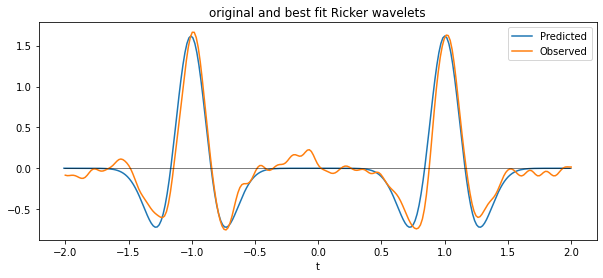

In [14]:
ru.plotrickers(tpred_final,wpred_final,tobs,wobs,title='original and best fit Ricker wavelets',filename='Figures/Best-fit.pdf')

This is the best fit model Figure 8 of Sambridge et al. (2022), albeit with a different realization of correlated noise on the orange trace. 

In [15]:
was,mods,wfs = ru.findres(ricker_util_opt.Wits,ricker_util_opt.Wdata) # collect Wasserstein distances, models and predicted waveforms for each iteration

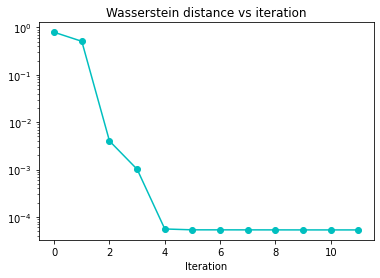

In [16]:
ru.plotmisfit(was,log=True)

In [17]:
ls = []
for i in range(len(was)):
    ls.append(ru.LSmisfit(tobs,wobs,wfs[i].p.T[0],wfs[i].p.T[1]))

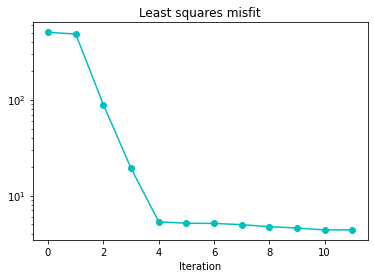

In [18]:
ru.plotmisfit(ls,title='Least squares misfit',log=True,filename='Figures/L2_opt_log.pdf') # plot Least squares misfits

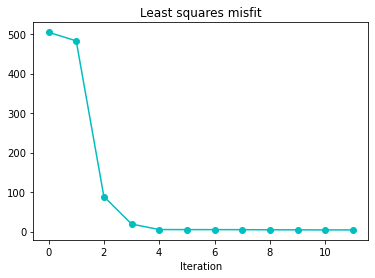

In [19]:
ru.plotmisfit(ls,title='Least squares misfit',filename='Figures/L2_opt_lin.pdf') # plot Least squares misfits

The traces of $W_2^2$ and $L_2^2$ along the iteration path are equivalent to Figure 8 of Sambridge et al. (2022), for this dataset.